A first pass at digital frequency synthesis is relatively easy to pull off using some simple tricks in Python. It's not rocket science to string together a basic accumulator and a sine lookup table to make a sine wave output. However, we left off noting some spurious output in the synthesized sine wave. What can we do about that? 

Can't go anywhere until you fire up some data libraries:

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import dds

%matplotlib inline

Matplotlib created a temporary config/cache directory at /var/folders/rf/wfq6hz5s56g3yh4wqgd7820c0000gn/T/matplotlib-ju97ail7 because the default path (/Users/nreilly/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


...and now I wave the magic wand of functions...

In [2]:
freq     = 2822400
tuning   = dds.freq_to_tuning(freq)
phase    = dds.generate_phase_array(tuning)
df_phase = dds.generate_dds_frame(phase, tuning, dither_output=False)
df_fft   = dds.generate_dds_spectrum(df_phase['dds_out'])

...and receive those sweet, sweet Fourier coefficients in return:

<ipython-input-3-b49248555e02>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,2)


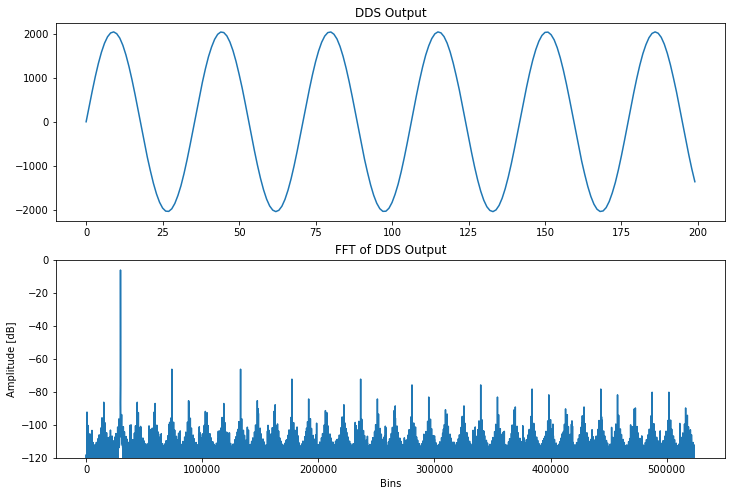

In [3]:
# Shortening the time domain plot so sine features are visible
plot_len = 200

fig = plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(df_phase['dds_out'][:plot_len])
plt.title("DDS Output")

plt.subplot(2,1,2)
ax = fig.add_subplot(2,1,2)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])

fft_index = int(len(df_fft['fft_mag_norm'])/2) # Half of the FFT output 
plt.plot(df_fft['fft_mag_norm'][:fft_index])
plt.title("FFT of DDS Output")
plt.xlabel('Bins')
plt.ylabel('Amplitude [dB]')
#plt.xlim(29590,29600)
plt.show()

In [ ]:
df_phase

In [5]:
df_phase = dds.generate_dds_frame(phase, tuning, dither_output=False)
df_fft   = dds.generate_dds_spectrum(df_phase['dds_out'])

phase_dither = dds.generate_dds_frame(phase, tuning, dither_output=True)
df_dither_fft   = dds.generate_dds_spectrum(phase_dither['dds_out'])

phase_dither

,phase,tuning,phase_trunc,dds_out
0,0,121221156,0,0
1,121745444,121221156,116,362
2,242966600,121221156,228,701
3,363663468,121221156,344,1031
4,484884624,121221156,460,1328
...,...,...,...,...
1048571,127108989292364,121221156,3552,-1517
1048572,127109109989232,121221156,3668,-1250
1048573,127109231734676,121221156,3784,-943
1048574,127109352431544,121221156,3900,-606


<ipython-input-8-9c02191a9784>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,1)
<ipython-input-8-9c02191a9784>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(2,1,2)


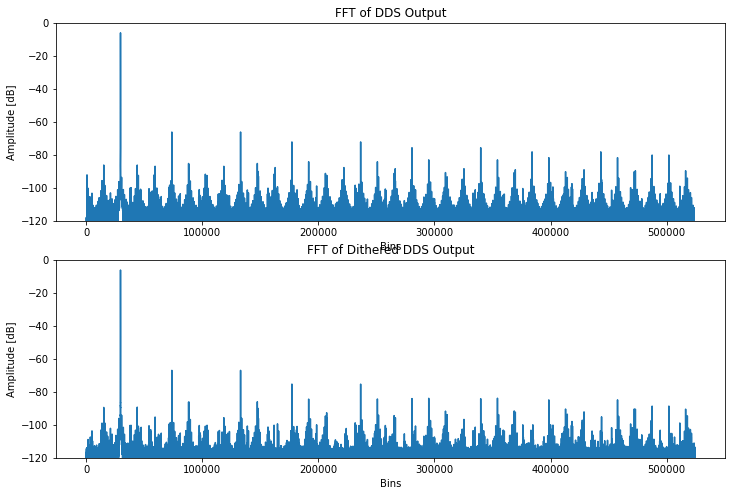

In [8]:
fig = plt.figure(figsize=(12,8))
fft_index = int(len(df_fft['fft_mag_norm'])/2) # Half of the FFT output

# First plot - undithered DDS output 
plt.subplot(2,1,1)
ax = fig.add_subplot(2,1,1)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])
fft_index = int(len(df_fft['fft_mag_norm'])/2) # Half of the FFT output 
plt.plot(df_fft['fft_mag_norm'][:fft_index])
plt.title("FFT of DDS Output")
plt.xlabel('Bins')
plt.ylabel('Amplitude [dB]')

# Second plot - dithered DS output 
plt.subplot(2,1,2)
ax = fig.add_subplot(2,1,2)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])

plt.plot(df_dither_fft['fft_mag_norm'][:fft_index])
plt.title("FFT of Dithered DDS Output")
plt.xlabel('Bins')
plt.ylabel('Amplitude [dB]')
plt.show()

Alright. So, the spurs. How do we get rid of 'em? 

The first thing you gotta realize is that, since the spurs are showing up in the FFT, they're _periodic_. So 

Remember how I talked a bit about error last time, and 

# Everything below this cell is old post 

Cool! There are a few regular tones that you can see peeking out of the noise in the FFT above. We care about these because these determine how spectrally pure the intended output is. Hip cats in the signal processing world call this the "spur free dynamic range", or SFDR. That's the official name for the difference between your desired signal's magnitude to the magnitude of the first undesirable harmonic. This is quick to find with a few lines of Python:  sort the magnitudes of the FFT bins, and subtract the second-highest magnitude bin from the the highest-magnitude bin (a.k.a. "the carrier").

In [ ]:
len_db_freqs = int(len(db_freqs)/2)
largest_peaks = sorted(db_freqs[:len_db_freqs])[-10:]
print(largest_peaks)
sfdr = largest_peaks[-1] - largest_peaks[-2]
print()
print(f"the SFDR of this signal is {sfdr} dBc")

So, what can we do about all of this excess noise, and these tones degrading our SFDR? 

There's a few more neat tricks on how to get around this, including:

* Increasing the bit depth of your sin rom
* Increasing the ROM depth of your sin rom
* Dithering
* Taylor series correction

I'll dig more into each of those in good time. 

# Dope Links for Cool Cats 


## Direct Digital Synthesis

Analog Devices has long been the leader in high speed DACs and ADCs, so, naturally, they'd know something about DDS. They've even gone so far as to bundle a complete DDS solution - NCO, phase-to-amplitude conversion, and DAC - into a single DDS chip. I've used the AD9837 before in my bFunc project. There are a few big brother parts to this one that - particularly the AD9102, which is basically a whole function generator on a chip. (Thanks to John Guy from ADI for telling me that exists!) Suffice it to say, they know a lot about DDS. This is probably the single densest resource on direct digital synthesis I've found yet: http://www.ieee.li/pdf/essay/dds.pdf 


Xilinx, the FPGA manufacturer, also has some great resources available to the DDS-curious. Since Xilinx focuses on higher end digital frequency synthesis applications, they get into the guts of DDS methods in a little more mathematical detail than ADI does. I really like this note's descriptions of methods to generate high SFDR waveforms.   
https://www.xilinx.com/support/documentation/ip_documentation/dds.pdf

## Matplotlib / Plotting
Python For Engineers had a great little tutorial on plotting sine and FFT waveforms. (It also reminded me how much easier it is to twiddle graph parameters with numpy rather than pandas.) 

https://www.pythonforengineers.com/audio-and-digital-signal-processingdsp-in-python/

I also leaned heavily on this answer to get nice-looking FFT plots in log formats:
https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel

In [ ]:
data_fft = np.fft.fft(df_phase['dds_out'])
frequencies = np.abs(data_fft)
freq_scale = frequencies * 2 / len(frequencies)
db_freqs = freq_scale / float(2**(bit_depth))
db_freqs = (20 * np.log10(db_freqs))

# Shortening the time domain plot so sine features are visible
plot_len = 200

fig = plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.plot(df_phase['dds_out'][:plot_len])
plt.title("DDS Output")

plt.subplot(3,1,2)
plt.plot(df_phase['phase_trunc'][:plot_len])
plt.title("Phase Accumulator (Truncated)")

# https://dsp.stackexchange.com/questions/32076/fft-to-spectrum-in-decibel
plt.subplot(3,1,3)
ax = fig.add_subplot(3,1,3)
ax.set_ylim(-120, 0)
ax.set_yticks([-120, -100, -80, -60, -40, -20, 0])
#ax.set_yscale('symlog')
fft_ticklabels = ax.get_xticklabels()
fft_ticklines = ax.get_xticklines()

#fft_index = int(len(frequencies)/2) # Half of the FFT output 
#fft_index = 5000
#plt.plot(db_freqs[:fft_index])
plt.plot(db_freqs)


plt.title("Frequencies found")
plt.xlim(0,fft_index)
plt.show()